#### > Gozde Orhan

# Spam or Ham? - Natural Language Processing Project
### Project Scope: SMS Spam Detection

In [2]:
import numpy as np
import pandas as pd

#tqdm package is used for for-loops in order to track the process of it.
from tqdm import tqdm_notebook as tqdm

#os package is used to get the data sizes in bytes.
import os

### Exploratory analysis

In academic settings, the main drawback of SMS spam detection is the scarcity of public SMS spam datasets which are essential in any scientific research (Almeida et al 2011). However, during this project, the largest corpus consisting of real, public and non-encoded SMS spam collection extracted from various sources by Tiago Almeida and his colleagues will be used.

This collection contains 4,825 legitimate (ham) messages and 747 spam messages in English with a total number of 5,572 short messages. This indicates that the major percentage of the data with the percentage of 86.6 are labelled as ham where only 13.4% of them labelled as spam. The dataset was found in a .csv format where each row corresponds to a single message and is composed of two columns: label (v1) and the raw text (v2).

Link to dataset: https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

In [3]:
#Read data
data = pd.read_csv('spam.csv')

print('Number of rows in the dataset: '+ str(len(data)))
print('Size of the file: ' + str(os.path.getsize('/Users/gozdeorhan/Desktop/spam.csv')) + ' bytes.')

data.isna().sum()

Number of rows in the dataset: 5572
Size of the file: 499428 bytes.


v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [4]:
#Drop columns not related to analysis
df = data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis = 1)

df.isna().sum()

v1    0
v2    0
dtype: int64

In [5]:
#Rename columns
df = df.rename(columns={"v1":"label", "v2":"text"})
df.head(2)

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


In [6]:
#Percentage of labels
import matplotlib.pyplot as plt

df["label"].value_counts().plot(kind = 'pie', startangle=90,explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True, textprops={'fontsize': 15})
plt.ylabel("Spam vs Ham", fontsize = 20)
plt.legend(["Ham", "Spam"], fontsize = 15)
plt.show()

<Figure size 600x600 with 1 Axes>

<img src="pie.png" width="200" />

### Exploratory analysis cont'd

In [7]:
#Descriptives of each group
df.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

It is seen that not all messages are unique. There are more frequent messages sent than others. For messages labelled as ‘Ham’, there are 4,516 unique messages with ‘Sorry, I’ll call later’ being the most frequent one. On the other hand, among spam messages, ’Please call our customer service representative on 0800 169 6031 between 10am- 9pm as you have WON a guaranteed £1000 cash or £5000 prize!’ message is sent more frequently than other spam messages.

Another analysis carried out was to check the length of the messages to see whether they might be indicative or not. After the analysis, it is seen that the average length of messages is 80.1 where the standard deviation is 59.7. Shortest SMS sent is 2 words long where the longest SMS sent is 910 words long! 

In [8]:
#Checking the length of messages
#Adding new column named 'Length'
df["Length"] = df["text"].apply(len)
df["Length"].describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: Length, dtype: float64

In [9]:
df[df["label"] == "spam"]["Length"].describe()

count    747.000000
mean     138.866131
std       29.183082
min       13.000000
25%      132.500000
50%      149.000000
75%      157.000000
max      224.000000
Name: Length, dtype: float64

In [10]:
df[df["label"] == "ham"]["Length"].describe()

count    4825.000000
mean       71.023627
std        58.016023
min         2.000000
25%        33.000000
50%        52.000000
75%        92.000000
max       910.000000
Name: Length, dtype: float64

In [11]:
df.head()

,label,text,Length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


/anaconda3/envs/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


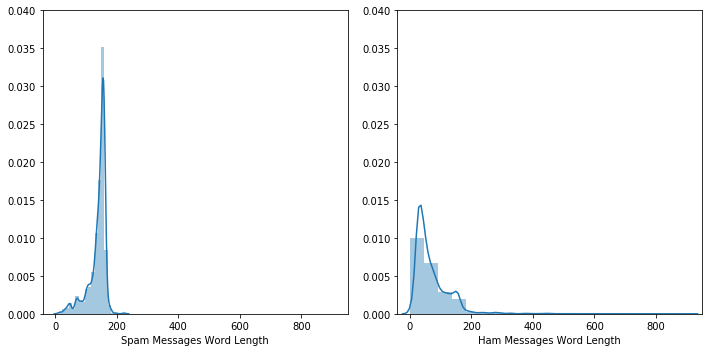

In [12]:
#Plotting length feature
import seaborn as sns

f, ax = plt.subplots(1, 2, figsize = (10, 5))

sns.distplot(df[df["label"] == "spam"]["Length"], bins = 20, ax = ax[0])
ax[0].set_xlabel("Spam Messages Word Length")
ax[0].set_xlim([-40, 950])
ax[0].set_ylim([0, 0.04])



sns.distplot(df[df["label"] == "ham"]["Length"], bins = 20, ax = ax[1])
ax[1].set_xlabel("Ham Messages Word Length")
ax[1].set_xlim([-40, 950])
ax[1].set_ylim([0, 0.04])


plt.tight_layout()
plt.savefig('length',dpi=300)
plt.show()

From the above table and figure, it can be clearly seen that spam messages are more likely to be longer and have less standard deviation whereas ham messages have greater standard deviation but tend to be shorter. However, since the two classes are imbalanced, it is decided that the difference is not significant enough to use length feature as a predictor.

### Pre-processing

Following the exploratory analysis of the data without any pre-processing steps are taken, it is decided to analyse the data furthermore after tokenization process.

First, missing values are checked. It is seen that there are no missing values. Thus, no steps are taken in terms of handling missing values. 

Then, two functions are defined in order to tokenize and clean the raw text messages. These functions are defined first, to lower all the words, then remove any English stop-words and any string containing 1 or more non- alphabets. In this manner, it is aimed to analyse tokenized text messages. In this step, ham and spam texts are tokenized and cleaned separately.

In [13]:
# Text Preprocessing
import nltk
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize

In [14]:
#Extract spam and ham data seperately to look into further analysis of each class

spam_data = df[df["label"] == "spam"]["text"]
ham_data = df[df["label"] == "ham"]["text"]

spam_words = []
ham_words = []

#Functions to tokenize, lower and
#remove any English stop-words and any string containing 1 or more non-alphabets

def extractSpamWords(spamMessages):
    global spam_words
    words = [word.lower() for word in word_tokenize(spamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    spam_words = spam_words + words
    
spam_data1=spam_data.apply(extractSpamWords)
    
def extractHamWords(hamMessages):
    global ham_words
    words = [word.lower() for word in word_tokenize(hamMessages) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]
    ham_words = ham_words + words

hamd_data1=ham_data.apply(extractHamWords)

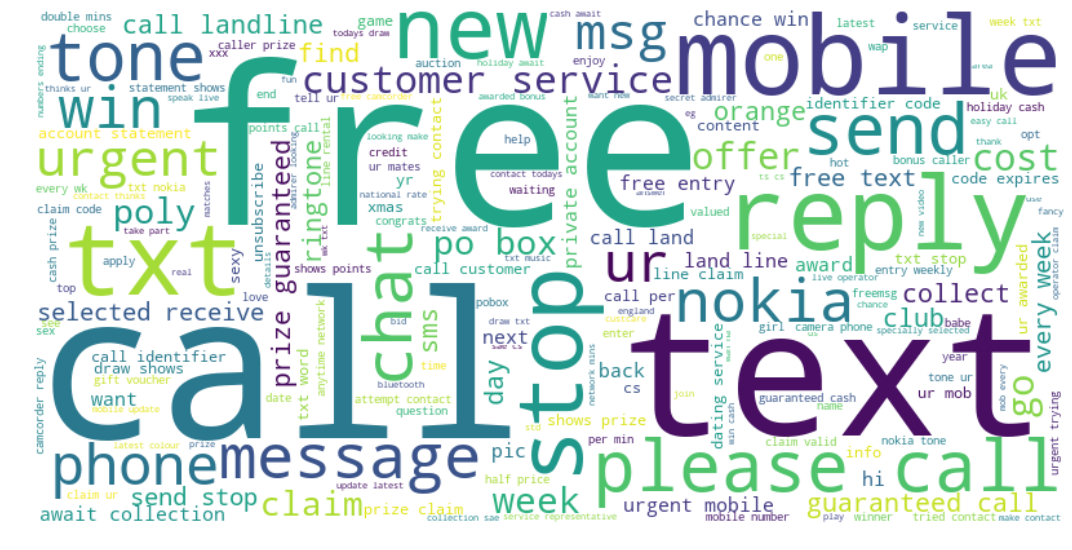

In [15]:
from wordcloud import WordCloud

#Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white",width=800, height=400).generate(" ".join(spam_words))

#Display the generated image:
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.tight_layout()
plt.show()

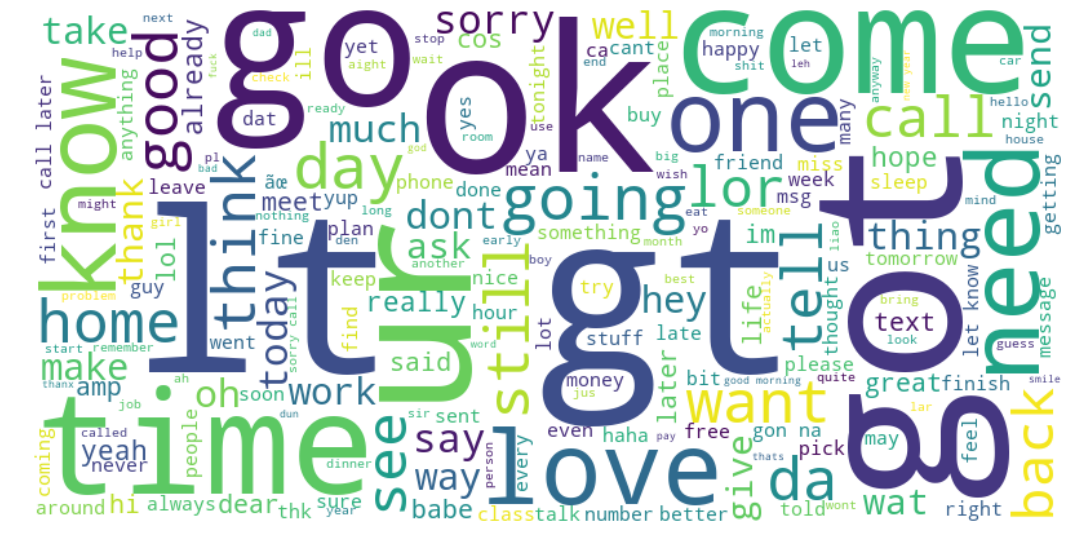

In [16]:
#Create and generate a word cloud image:
wordcloud2 = WordCloud(background_color="white",width=800, height=400).generate(" ".join(ham_words))

#Display the generated image:
plt.figure(figsize=(15,8))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")

plt.tight_layout()
plt.show()

In [17]:
#Check frequency of tokens
fd_spam = nltk.FreqDist(spam_words)
display('There are ' + str(len(fd_spam)) + ' unique tokens')
df_spam=pd.DataFrame(list(fd_spam.items()), 
             columns = ["Token","Frequency"]).sort_values('Frequency',ascending=False)[0:20]
display(df_spam)

'There are 1698 unique tokens'

,Token,Frequency
42,call,346
0,free,217
14,txt,156
48,u,144
86,ur,144
46,mobile,123
10,text,121
243,stop,114
41,claim,113
63,reply,104


In [18]:
#Check frequency of tokens
fd_ham = nltk.FreqDist(ham_words)
display('There are ' + str(len(fd_ham)) + ' unique tokens')
df_ham=pd.DataFrame(list(fd_ham.items()), 
             columns = ["Token","Frequency"]).sort_values('Frequency',ascending=False)[0:20]
display(df_ham)

'There are 6242 unique tokens'

,Token,Frequency
19,u,974
226,gt,318
225,lt,316
229,get,301
0,go,246
15,ok,246
12,got,242
117,ur,237
154,know,234
36,like,231


### Pre-processing cont'd

For the sake of a better classification, besides the previous pre-processing, stemming and removal of punctuation are also done. Stemming is the process of reducing inflexion in words to their root forms. Through stemming, it is aimed that models will perform better since grouping tokens with the same roots together may strengthen the predictive power of the tokens.

In [19]:
#Stem, remove stopwords, punctuation, split
df_c=df.copy()

from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("english")

def cleanText(message):
    
    message = message.translate(str.maketrans('', '', string.punctuation))
    words = [stemmer.stem(word) for word in message.split() if word.lower() not in stopwords.words("english")]
    
    return " ".join(words)

df_c["text"] = df_c["text"].apply(cleanText)
df_c.head(10)  

,label,text,Length
0,ham,go jurong point crazi avail bugi n great world...,111
1,ham,ok lar joke wif u oni,29
2,spam,free entri 2 wkli comp win fa cup final tkts 2...,155
3,ham,u dun say earli hor u c alreadi say,49
4,ham,nah dont think goe usf live around though,61
5,spam,freemsg hey darl 3 week word back id like fun ...,148
6,ham,even brother like speak treat like aid patent,77
7,ham,per request mell mell oru minnaminungint nurun...,160
8,spam,winner valu network custom select receivea â£9...,158
9,spam,mobil 11 month u r entitl updat latest colour ...,154


## Training

The dataset is split into two: a training set and a test set. 25% of the data is designated as test set whereas the remaining is kept as the training set. Now, the training set contains 4,179 messages where the test set contains 1,393 messages. As discussed before, the length feature is not considered as one of the predictors. Hence, only the column named ‘text’ is used as the predictor column and the ‘label’ column is selected as the target value.

In [20]:
from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


np.random.seed(670)

#Split training and test set
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df_c['text'],df_c['label'],test_size=0.25)

In [21]:
#Number of messages in training set
len(Train_X)

4179

In [22]:
#Number of messages in test set
len(Test_X)

1393

In [23]:
classifiers = [LogisticRegression(solver='lbfgs'), MultinomialNB(), KNeighborsClassifier(2), 
               DecisionTreeClassifier(), RandomForestClassifier(n_estimators=100),
               AdaBoostClassifier(), GradientBoostingClassifier()]

### TF-IDF and label transformation
At this stage, in order to feed text documents into the model, turning them into numerical feature vectors is required. Despite the fact that there are many methods to convert text data to vectors which the model can understand, by far the most popular method is called TF-IDF. 

This is an acronym that stands for “Term Frequency - Inverse Document” Frequency which are the components of the resulting scores assigned to each word. Hence, tokenized text messages are converted to a matrix of TF-IDF features. The reason behind using the TF-IDF score is to highlight words that are more ‘interesting’ or how ‘important’ a word is. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.


In addition, our target column ‘label’ is encoded as 0-1 where 0 represents ham messages and 1 represents spam messages.

<img src="example.png" width="800" />

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

feature_list=[]
classifier_list=[]
accuracy_list=[]
f1_list=[]

trial =[500,600,700,800,900,1000,1500,2000,2500,3000]

for i in tqdm(trial):
    print('=================================== ' + str(i) + ' ===================================')
    for j in classifiers:
        
        name = j.__class__.__name__

        #tf-idf transformation
        Tfidf_vect = TfidfVectorizer(max_features=i)
        Tfidf_vect.fit(df_c['text'])

        Train_X_Tfidf = Tfidf_vect.transform(Train_X)
        Test_X_Tfidf = Tfidf_vect.transform(Test_X)

        #Encoding labels into numerical values
        Encoder = LabelEncoder()
        Train_Y = Encoder.fit_transform(Train_Y)
        Test_Y = Encoder.fit_transform(Test_Y)

        # fit the training dataset on the classifier
        classifier = j
        classifier.fit(Train_X_Tfidf,Train_Y)

        # predict the labels on validation dataset
        predictions = classifier.predict(Test_X_Tfidf)
        
        feature_list.append(i)
        classifier_list.append(name)
        accuracy_list.append(accuracy_score(predictions, Test_Y)*100)
        f1_list.append(f1_score(predictions, Test_Y, average='weighted')*100)

        # Use accuracy_score function to get the accuracy
        print(' ')
        print(name + ' Accuracy Score with max feature of ' + str(i) + ' -> ',accuracy_score(predictions, Test_Y)*100)
        print(name + ' F1 Score with max feature of ' + str(i) + '       -> ',f1_score(predictions, Test_Y, average='weighted')*100)
        print(confusion_matrix(predictions, Test_Y))

=================================== 500 ===================================
 
LogisticRegression Accuracy Score with max feature of 500 ->  96.69777458722182
LogisticRegression F1 Score with max feature of 500       ->  96.85297189592914
[[1189   43]
 [   3  158]]
 
MultinomialNB Accuracy Score with max feature of 500 ->  97.34386216798278
MultinomialNB F1 Score with max feature of 500       ->  97.41814803115638
[[1186   31]
 [   6  170]]
 
KNeighborsClassifier Accuracy Score with max feature of 500 ->  93.75448671931083
KNeighborsClassifier F1 Score with max feature of 500       ->  94.41809541923585
[[1188   83]
 [   4  118]]
 
DecisionTreeClassifier Accuracy Score with max feature of 500 ->  96.33883704235463
DecisionTreeClassifier F1 Score with max feature of 500       ->  96.38192909593936
[[1172   31]
 [  20  170]]
 
RandomForestClassifier Accuracy Score with max feature of 500 ->  97.77458722182341
RandomForestClassifier F1 Score with max feature of 500       ->  97.83148051437

 
GradientBoostingClassifier Accuracy Score with max feature of 1000 ->  96.8413496051687
GradientBoostingClassifier F1 Score with max feature of 1000       ->  96.95702167797745
[[1186   38]
 [   6  163]]
=================================== 1500 ===================================
 
LogisticRegression Accuracy Score with max feature of 1500 ->  96.33883704235463
LogisticRegression F1 Score with max feature of 1500       ->  96.55607297593738
[[1191   50]
 [   1  151]]
 
MultinomialNB Accuracy Score with max feature of 1500 ->  98.06173725771716
MultinomialNB F1 Score with max feature of 1500       ->  98.12066173136226
[[1192   27]
 [   0  174]]
 
KNeighborsClassifier Accuracy Score with max feature of 1500 ->  92.7494615936827
KNeighborsClassifier F1 Score with max feature of 1500       ->  93.78941193511427
[[1191  100]
 [   1  101]]
 
DecisionTreeClassifier Accuracy Score with max feature of 1500 ->  96.4824120603015
DecisionTreeClassifier F1 Score with max feature of 1500       ->

In [25]:
print(Train_X_Tfidf)

  (0, 1207)	0.5631223340194422
  (0, 1431)	0.519675938351853
  (0, 2654)	0.6425186036424291
  (1, 421)	0.38503700538609476
  (1, 861)	0.42017994883433973
  (1, 1839)	0.5154476172526042
  (1, 2634)	0.49381233969710625
  (1, 2858)	0.40701159948134485
  (2, 25)	0.3477677807197035
  (2, 46)	0.28428378769365964
  (2, 59)	0.2562165146196281
  (2, 73)	0.25274541475060475
  (2, 97)	0.3135400951622805
  (2, 336)	0.23417598187666983
  (2, 486)	0.1368457963741795
  (2, 565)	0.2078828508227491
  (2, 1063)	0.24032617575943033
  (2, 1385)	0.2777774066363494
  (2, 1431)	0.2437736363504906
  (2, 1616)	0.19986888344596224
  (2, 1763)	0.21190569619159605
  (2, 1973)	0.21778365973944389
  (2, 2711)	0.23008815122985898
  (2, 2733)	0.27214132300375027
  (3, 102)	0.6948718393577271
  :	:
  (4176, 56)	0.28712415495736143
  (4176, 62)	0.2447411379065512
  (4176, 171)	0.2777751153994232
  (4176, 539)	0.23539209834861294
  (4176, 752)	0.34424530427229894
  (4176, 897)	0.22184261047484272
  (4176, 1138)	0.345205

## Results

I have experimented with numerous well-known machine learning algorithms in the task of SMS spam detection using the SMS Spam Collection which is accessible via the UCI Machine Learning Repository. In addition to implementing different algorithms, I also experimented with the number of maximum features set during the usage of TfidfVectorizer (max_features=i).

In order to assess the performance of ML methods, as well as the accuracy score, the **F1 score is also taken into consideration. The reason why there is a need for an additional metric is due to the fact that the two classes (spam/ham) are not balanced! Hence, only looking into accuracy might be deceiving.**

F1 score is defined as the harmonic mean between precision and recall. The definition of recall is the number of true positives divided by the number of true positives plus the number of false negatives. Recall can be thought as of a model’s ability to find all the data points of interest in a dataset. However, recall is not also enough by itself since only maximizing recall will lead to low precision. While recall expresses the ability to find all relevant instances in a dataset, precision expresses the proportion of the data points our model says was relevant actually were relevant. Also, the harmonic mean is being used instead of a simple average because it punishes extreme values. Hence, the F1 score is an important metric to evaluate an imbalanced classification problem’s performance (Koehrsen, 2018).

In [26]:
#Creating results table
table = pd.DataFrame({'Features' : feature_list, 'Classifier' : classifier_list, 'Accuracy Score' : accuracy_list,
                     'F1 Score' : f1_list})    

table.head()

,Features,Classifier,Accuracy Score,F1 Score
0,500,LogisticRegression,96.697775,96.852972
1,500,MultinomialNB,97.343862,97.418148
2,500,KNeighborsClassifier,93.754487,94.418095
3,500,DecisionTreeClassifier,96.338837,96.381929
4,500,RandomForestClassifier,97.774587,97.831481


In [27]:
#Based on https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html

cm = sns.light_palette("orange", as_cmap=True)

s = table.style.background_gradient(cmap=cm,subset=['Accuracy Score', 'F1 Score'])
s

,Features,Classifier,Accuracy Score,F1 Score
0,500,LogisticRegression,96.6978,96.853
1,500,MultinomialNB,97.3439,97.4181
2,500,KNeighborsClassifier,93.7545,94.4181
3,500,DecisionTreeClassifier,96.3388,96.3819
4,500,RandomForestClassifier,97.7746,97.8315
5,500,AdaBoostClassifier,96.7696,96.8678
6,500,GradientBoostingClassifier,96.6978,96.8271
7,600,LogisticRegression,96.7696,96.9257
8,600,MultinomialNB,97.3439,97.4181
9,600,KNeighborsClassifier,93.4673,94.2545


- It is seen that, regardless of the maximum feature number, in every case, the best two classifiers were Random Forest and Multinomial Naïve Bayes. Both accuracy and F1 Scores for these classifiers were between 97%-98% which is significantly high and desirable. Hence, both classifiers can be said to be the best classifiers to detect SMS Spams for this dataset.

In [28]:
#Based on https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
#Function to highlight best performing model

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

In [29]:
table.style.apply(highlight_max, subset=['Accuracy Score', 'F1 Score'])

,Features,Classifier,Accuracy Score,F1 Score
0,500,LogisticRegression,96.6978,96.853
1,500,MultinomialNB,97.3439,97.4181
2,500,KNeighborsClassifier,93.7545,94.4181
3,500,DecisionTreeClassifier,96.3388,96.3819
4,500,RandomForestClassifier,97.7746,97.8315
5,500,AdaBoostClassifier,96.7696,96.8678
6,500,GradientBoostingClassifier,96.6978,96.8271
7,600,LogisticRegression,96.7696,96.9257
8,600,MultinomialNB,97.3439,97.4181
9,600,KNeighborsClassifier,93.4673,94.2545


**It is seen that experiment with id number 46 is outperformed with an accuracy score of 98.2% and an F1 score of 98.25%. This experiment is used maximum feature number as 1,500 and used Random Forest as a classifier.**